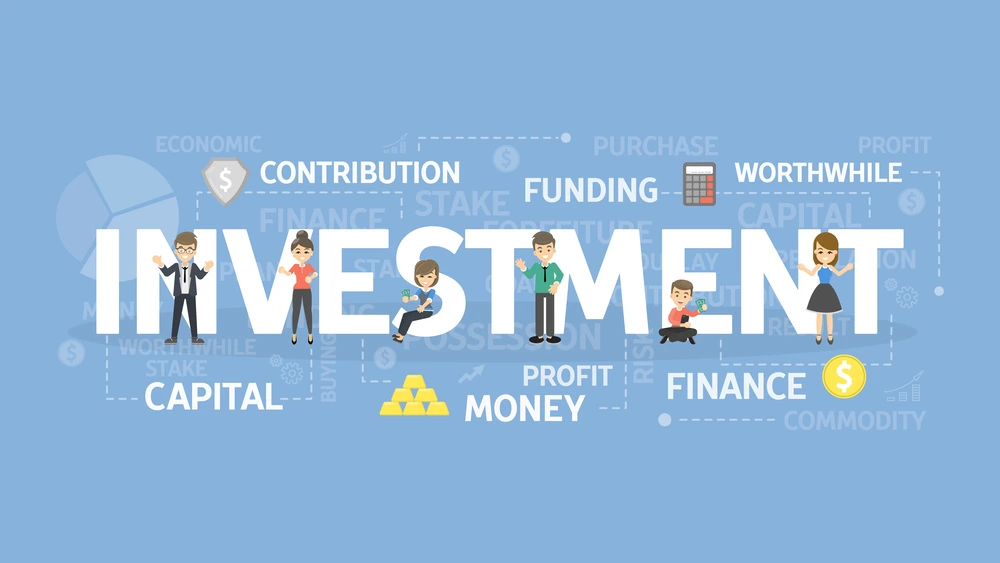

## Introduction
This project explores customer investment behavior across various asset classes using a dataset of 12,000 transactions over multiple years. The goal is to uncover trends in asset preferences, track average returns over time, and segment users by investment size and frequency.

#### The dataset
This dataset contains the following features:
- `Customer ID`: The customer's ID
- `Gender`: Male or Female
- `Age`: The customer's age
- `Region`: The customer's state
- `Date:` The date the investment was made
- `Investment Type`: Stock, bond, crypto, etc.
- `Amount Invested`: Customer's Capital
- `ROI`: Customer's return on investment
- `Customer Join Date`: Date customer joined
- `Risk Profile`: Customer's risk profile
- `Last Investment Date`: Date last investment was made by customer


In [1]:
#import relevant libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

#import dataset
df = pd.read_csv('investment_trends_dataset.csv')
df.head()

,CustomerID,Gender,Age,Region,Date,InvestmentType,Amount,ROI,CustomerJoinDate,RiskProfile,LastInvestmentDate
0,INV00088,Male,20,Port Harcourt,11/2/23,Mutual Fund,14174.79,668.30,1/25/22,Medium,9/27/24
1,INV00810,Male,39,Kano,10/9/24,Fixed Income,28842.26,641.62,11/18/23,Medium,12/26/24
2,INV00684,Female,41,Abuja,7/7/23,Mutual Fund,4411.04,216.18,5/14/22,Medium,5/9/24
3,INV01683,Other,23,Port Harcourt,6/24/23,Crypto,18967.37,4290.20,2/11/23,Medium,6/8/24
4,INV02582,Female,67,Abuja,10/14/24,Fixed Income,1440.70,45.99,10/4/21,Medium,10/14/24


## Data Cleaning & Preparation

In [2]:
def explorer(data):
    '''This function does a full exploration of the dataset.'''
    print('====== Data Information ======')
    print('\n')
    info = print(data.info())
    print('='*20)
    print('\n')
    print('====== Descriptive Statistics ======')
    desc = print(data.describe(include = 'all'))
    print('='*20)
    print('\n')
    print('====== Unique Entries ======')
    uniq = print(data.nunique())
    print('='*20)
    return info, desc, uniq

explorer(df)

====== Data Information ======


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          12000 non-null  object 
 1   Gender              12000 non-null  object 
 2   Age                 12000 non-null  int64  
 3   Region              12000 non-null  object 
 4   Date                12000 non-null  object 
 5   InvestmentType      12000 non-null  object 
 6   Amount              12000 non-null  float64
 7   ROI                 12000 non-null  float64
 8   CustomerJoinDate    12000 non-null  object 
 9   RiskProfile         12000 non-null  object 
 10  LastInvestmentDate  12000 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.0+ MB
None


====== Descriptive Statistics ======
       CustomerID  Gender           Age Region    Date InvestmentType  \
count       12000   12000  12000.000000  1

(None, None, None)

From the descriptive output above, we can see that there are 12000 non-null rows and 11 columns. We also have 3 numeric columns (`Age`, `Amount`, and `ROI`), while others are non-numeric. The data also showed that this company has `2935 unique customers`, with ages ranging between `20-69 years`. From the dataset, we also observe that investment amount ranges from `₦1,000 to ₦127,979` with a mean of `₦10,240`; return on investment is highly variable `(-₦52,934 to +₦66,492)`, with an average return of `₦868`.

Looking at the dataset through the data cleaning lens, we notice that the dataset is largely clean, apart from the datatype issues with the date columns (`Date`,`CustomerJoinDate`, and `LastInvestmentDate`). This will be addressed immediately.

In [3]:
#Correcting the date datatypes

date_cols = ['Date','CustomerJoinDate','LastInvestmentDate']

for col in df[date_cols]:
    df[col] = pd.to_datetime(df[col])

df

,CustomerID,Gender,Age,Region,Date,InvestmentType,Amount,ROI,CustomerJoinDate,RiskProfile,LastInvestmentDate
0,INV00088,Male,20,Port Harcourt,2023-11-02,Mutual Fund,14174.79,668.30,2022-01-25,Medium,2024-09-27
1,INV00810,Male,39,Kano,2024-10-09,Fixed Income,28842.26,641.62,2023-11-18,Medium,2024-12-26
2,INV00684,Female,41,Abuja,2023-07-07,Mutual Fund,4411.04,216.18,2022-05-14,Medium,2024-05-09
3,INV01683,Other,23,Port Harcourt,2023-06-24,Crypto,18967.37,4290.20,2023-02-11,Medium,2024-06-08
4,INV02582,Female,67,Abuja,2024-10-14,Fixed Income,1440.70,45.99,2021-10-04,Medium,2024-10-14
...,...,...,...,...,...,...,...,...,...,...,...
11995,INV01870,Female,47,Kano,2023-07-09,Mutual Fund,1193.03,89.93,2022-06-13,Medium,2024-12-07
11996,INV01632,Male,38,Kano,2022-03-05,Fixed Income,21248.03,788.98,2021-06-06,Low,2023-09-27
11997,INV01144,Male,31,Lagos,2021-01-06,Crypto,6204.79,30.79,2020-09-01,Medium,2024-11-20
11998,INV00882,Female,44,Kano,2024-01-19,Fixed Income,17048.94,254.48,2022-02-12,Low,2024-01-19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CustomerID          12000 non-null  object        
 1   Gender              12000 non-null  object        
 2   Age                 12000 non-null  int64         
 3   Region              12000 non-null  object        
 4   Date                12000 non-null  datetime64[ns]
 5   InvestmentType      12000 non-null  object        
 6   Amount              12000 non-null  float64       
 7   ROI                 12000 non-null  float64       
 8   CustomerJoinDate    12000 non-null  datetime64[ns]
 9   RiskProfile         12000 non-null  object        
 10  LastInvestmentDate  12000 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1), object(5)
memory usage: 1.0+ MB


In [5]:
# --- Data Cleaning & Feature Engineering ---
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['CustomerTenureDays'] = (df['Date'] - df['CustomerJoinDate']).dt.days
df['IsHighROI'] = (df['ROI'] > df['ROI'].median()).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CustomerID          12000 non-null  object        
 1   Gender              12000 non-null  object        
 2   Age                 12000 non-null  int64         
 3   Region              12000 non-null  object        
 4   Date                12000 non-null  datetime64[ns]
 5   InvestmentType      12000 non-null  object        
 6   Amount              12000 non-null  float64       
 7   ROI                 12000 non-null  float64       
 8   CustomerJoinDate    12000 non-null  datetime64[ns]
 9   RiskProfile         12000 non-null  object        
 10  LastInvestmentDate  12000 non-null  datetime64[ns]
 11  Year                12000 non-null  int32         
 12  Month               12000 non-null  int32         
 13  CustomerTenureDays  12000 non-null  int64     

## Exploratory Analysis

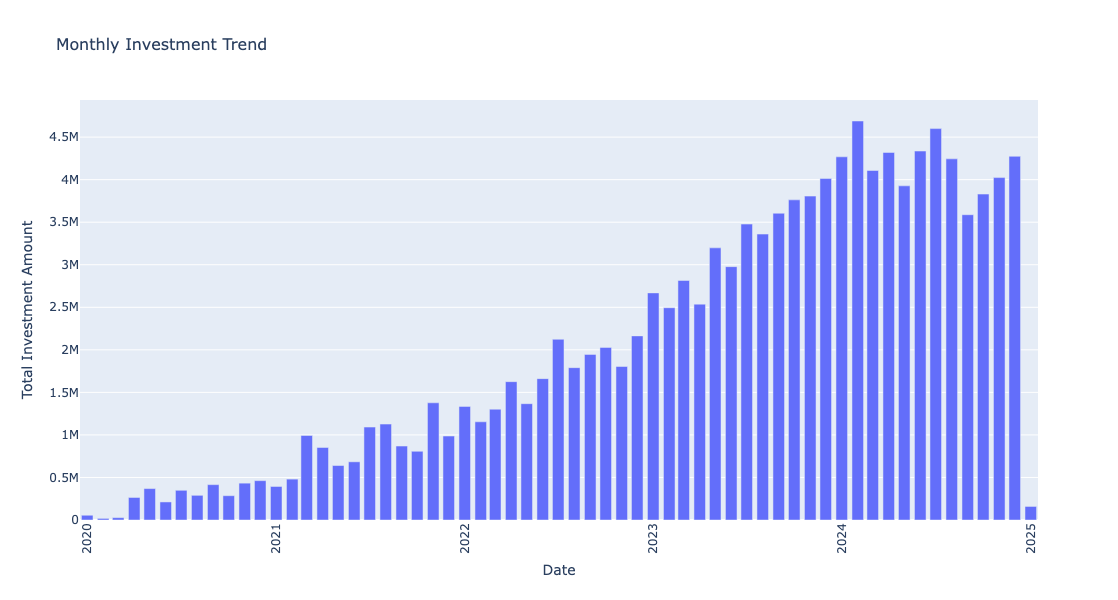

In [10]:
# Group and prepare the data
monthly_investment = df.groupby(['Year', 'Month'])['Amount'].sum().reset_index()
monthly_investment['Date'] = pd.to_datetime(monthly_investment[['Year', 'Month']].assign(DAY=1))

# Plot using Plotly Express
fig = px.bar(
    monthly_investment,
    x='Date',
    y='Amount',
    title='Monthly Investment Trend',
    labels={'Date': 'Date', 'Amount': 'Total Investment Amount'}
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Total Investment Amount',
    title_font_size=16,
    xaxis_tickangle=-90,
    width = 1150,
    height = 600
)

fig.show()


From early 2020 to late 2024, monthly investments showed a consistent upward trend, indicating growing investor activity or confidence, with a notably steeper increase in the rate of investment growth occurring around early 2021, potentially due to market recovery, policy changes, or successful financial products. This growth culminated in peak monthly investment values exceeding `4.5 million` in early to mid-2024, suggesting a period of heightened investor interest or market performance.

Next, we turn our attention to asset classes to understand how investors interacted with different investment instruments during the period.

  InvestmentType    Amount
2    Mutual Fund  10480.85
3    Real Estate  10263.28
4         Stocks  10242.47
1   Fixed Income  10113.90
0         Crypto  10097.39


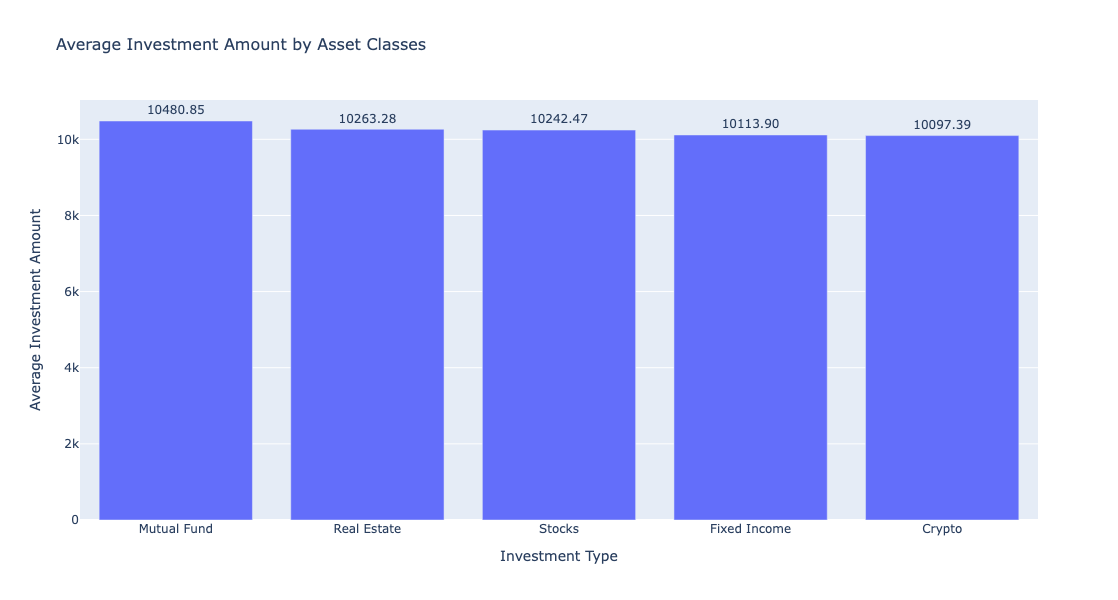

In [47]:
# Group and prepare the data
invtype_data = round(df.groupby('InvestmentType')['Amount'].mean().reset_index(), 2)
invtype_data = invtype_data.sort_values('Amount', ascending=False)

print(invtype_data)

# Plot using Plotly Express
fig = px.bar(
    invtype_data,
    x='InvestmentType',
    y='Amount',
    #orientation = 'h',
    text='Amount',
    title='Average Investment Amount by Asset Classes',
    labels={'InvestmentType': 'Investment Type', 'Amount': 'Average Amount'})

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Investment Type',
    yaxis_title='Average Investment Amount',
    title_font_size=16,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    width = 1000, height = 600)

fig.show()


The average investment amounts across all asset classes are relatively uniform, ranging narrowly from approximately `₦10,100` to `₦10,500`, suggesting a balanced investment strategy among investors. Notably, `Mutual Funds` exhibited the highest average investment at `₦10,480.85`, indicating stronger investor confidence or popularity, while `Crypto` shows the lowest average investment at around `₦10,097.39`, potentially reflecting perceived volatility or risk aversion. The minimal gaps between these averages imply a tendency towards even diversification rather than a heavy preference for a single asset class.



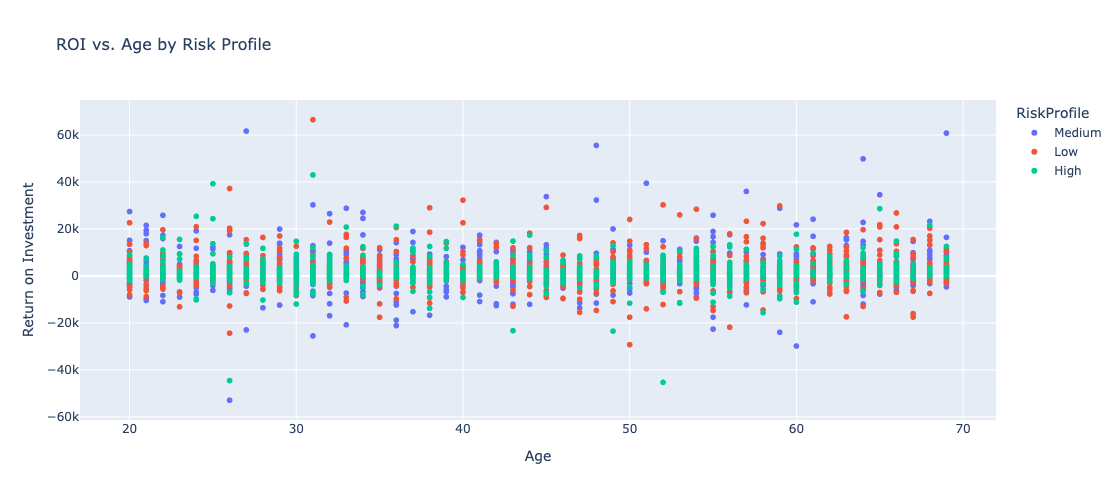

In [48]:
import plotly.express as px

# Scatterplot using Plotly Express
fig = px.scatter(
    df,
    x='Age',
    y='ROI',
    color='RiskProfile',
    title='ROI vs. Age by Risk Profile',
    labels={'Age': 'Age', 'ROI': 'Return on Investment'})

# Customize layout
fig.update_layout(
    width=800,
    height=500,
    title_font_size=16)

#fig.write_image('RiskProfile.png')  # Save as PNG (requires kaleido)
fig.show()

The chart above visualizes the interplay between investment returns, investor age, and risk tolerance, categorized as `Low`, `Medium`, and `High`. Each data point on the scatter plot represents a single investment, positioned horizontally by the investor's age and vertically by the achieved Return on Investment (ROI). The color of each point further distinguishes the investor's risk profile: blue signifies Medium risk, green indicates Low risk, and red denotes High risk.

Analysis of the chart reveals several key patterns. Investors across all age groups and risk profiles have experienced a diverse range of ROI outcomes, spanning from significant gains to substantial losses. Notably, there is no discernible trend suggesting a direct correlation between investor age and investment returns across the different risk categories. Furthermore, a higher concentration of investments appears around the lower positive and negative ROI values, implying that extreme investment outcomes might be less common. High-risk investments exhibit a wider dispersion of ROI, including both higher potential gains and losses, while low-risk investments tend to cluster within a narrower range of returns, typically closer to the zero mark.

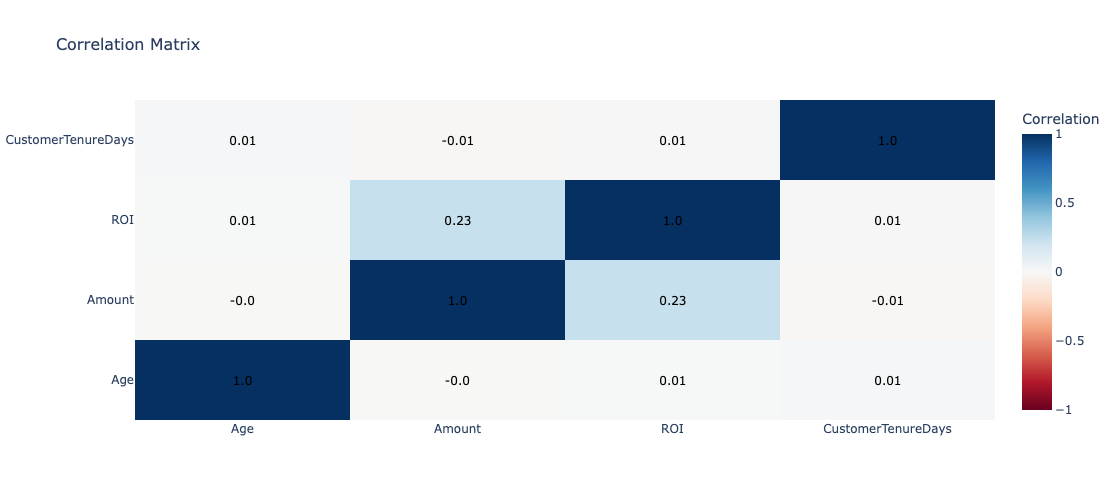

In [49]:
import plotly.graph_objects as go

# Compute the correlation matrix
corr_matrix = df[['Age', 'Amount', 'ROI', 'CustomerTenureDays']].corr()

# Create heatmap using plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    colorbar=dict(title='Correlation'),
    text=corr_matrix.round(2).values,
    hoverinfo='text'
))

# Add annotations (correlation values on top of each cell)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix.columns)):
        fig.add_annotation(
            x=corr_matrix.columns[j],
            y=corr_matrix.index[i],
            text=str(round(corr_matrix.iloc[i, j], 2)),
            showarrow=False,
            font=dict(color='black')
        )

# Update layout
fig.update_layout(
    title='Correlation Matrix',
    width=800,
    height=500,
    title_font_size=16
)

#fig.write_image('CorrelationMatrix.png')  # Save as PNG (requires kaleido)
fig.show()


The correlations between Amount and Age (-0.0), Amount and CustomerTenureDays (-0.01), ROI and Age (0.01), and ROI and CustomerTenureDays (0.01) are all very weak or negligible, indicating practically no linear relationship between these pairs of variables. A weak positive correlation (0.23) exists between Amount and ROI, suggesting a slight tendency for larger investments to be associated with somewhat higher returns, although this relationship is not strong.

          Region    Amount
0          Abuja  10542.71
4  Port Harcourt  10393.56
1          Enugu  10206.16
2           Kano  10102.78
3          Lagos   9983.60


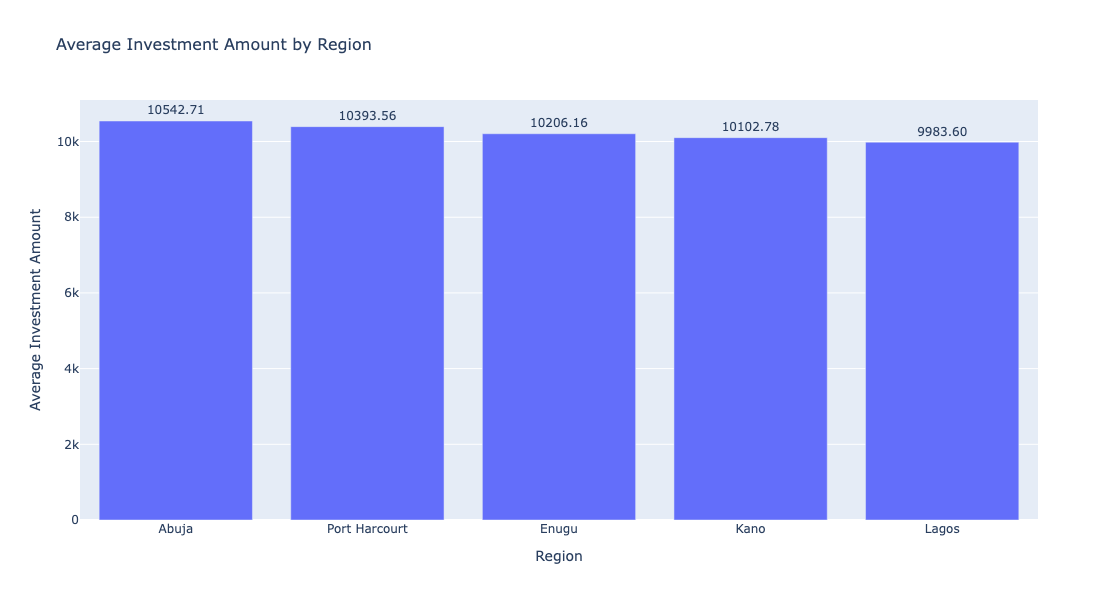

In [52]:
import plotly.express as px
import pandas as pd

# Prepare the data
region_data = round(df.groupby('Region')['Amount'].mean().reset_index(), 2)
region_data = region_data.sort_values('Amount', ascending=False)

# Optional: print the sorted data
print(region_data)

# Create bar chart with Plotly Express
fig = px.bar(
    region_data,
    x='Region',
    y='Amount',
    text='Amount',
    title='Average Investment Amount by Region',
    labels={'Region': 'Region', 'Amount': 'Average Investment Amount'}
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

fig.update_layout(
    xaxis_title='Region',
    yaxis_title='Average Investment Amount',
    title_font_size=16,
    width=1000,
    height=600,
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

#fig.write_image('InvestmentByRegion.png')  # Save as PNG (requires kaleido)
fig.show()


The bar chart above displays the average investment amount across five different regions: `Abuja`, `Port Harcourt`, `Enugu`, `Kano`, and `Lagos`. The height of each bar corresponds to the average investment amount for that specific region, with Abuja exhibiting the highest average investment at approximately `₦10,542.71`, followed closely by Port Harcourt at around `₦10,393.56` and Enugu at roughly `₦10,206.16`. Kano shows a slightly lower average investment of about `₦10,102.78`, while Lagos has the lowest average investment among the displayed regions at approximately `₦9,983.60`. Overall, the average investment amounts are relatively similar across these regions, with Abuja showing a marginal lead and Lagos having the lowest average investment.

**Insights & Recommendations**

- `Capitalize on the Growth Trend`: Leverage the observed upward trend in monthly investments from 2020 to late 2024 by understanding and potentially reinforcing the factors that contributed to this growth, particularly the significant surge after early 2021. This might involve further investigating the market recovery, policy changes, or the success of specific financial products that drove this increase.
- `Explore Mutual Fund Popularity`: Further analyze why Mutual Funds have the highest average investment. Understanding the specific characteristics or investor perceptions driving this preference can inform strategies for other asset classes.
- `Address Crypto Investment Aversion`: Investigate the reasons for the lower average investment in Crypto despite its hype. Understanding if this stems from perceived volatility, risk aversion, or lack of understanding can guide efforts to educate investors or potentially adjust offerings.
- `Monitor Diversification Trends`: Continue to observe the relatively uniform average investment across asset classes, which suggests a balanced diversification strategy. Understanding the drivers behind this could inform the development of products or advice that aligns with this preference.
- `Further Investigate ROI by Risk Profile and Age`: While no strong correlation was immediately apparent, the wider ROI range for high-risk investments and the narrower range for low-risk investments align with expectations. Further analysis could explore specific investment strategies within each risk profile and their performance across different age groups.
- `Regional Investment Strategies`: Acknowledge the slightly higher average investment in Abuja and the slightly lower average in Lagos. Further investigation into the economic factors or investor demographics in these regions could inform targeted strategies or product offerings.

## Diagnostic Analytics

###

In [57]:

def chi2_test(col1, col2, alpha = 5):
    import pandas as pd
    from scipy.stats import chi2_contingency
    # Assume your DataFrame is loaded into 'df'
    # --- Chi-Square Test: Gender vs. RiskProfile ---
    print("\n--- Chi-Square Test ---")

    # Create a contingency table
    contingency_table_gender_risk = pd.crosstab(col1, col2)#df['Gender'] df['RiskProfile']
    output = print("\nContingency Table:\n", contingency_table_gender_risk)

    # Perform the Chi-Square test
    chi2_gender_risk, p_gender_risk, dof_gender_risk, expected_gender_risk = chi2_contingency(contingency_table_gender_risk)

    output1 = print("\nChi-Square Statistic:", round(chi2_gender_risk,4))
    output2 = print("P-value:", round(p_gender_risk,4))
    output3 = print("Degrees of Freedom:", round(dof_gender_risk,4))
    output4 = print("\nExpected Frequencies Table (if independent):\n", expected_gender_risk)

    # Interpretation
    alpha = alpha/100
    #interpretation = print(f"\nReject the null hypothesis: There is a statistically significant association between {col1} and {col2}.") if  p_gender_risk < alpha else print(f"\nFail to reject the null hypothesis: There is no statistically significant association between {col1} and {col2}.")
    if p_gender_risk < alpha:
        print(f"\nReject the null hypothesis: There is a statistically significant association between {col1.name} and {col2.name}.")
    else:
        print(f"\nFail to reject the null hypothesis: There is no statistically significant association between {col1.name} and {col2.name}.")
    return output, output1, output2, output3, output4
